In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
from sklearn.linear_model import LassoCV, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor, plot_importance
from statsmodels.tsa.stattools import grangercausalitytests


In [10]:
# Load the data
eur_regression_df = pd.read_csv('eur_regression_dataW8.csv')

eur_regression_df = eur_regression_df.drop(columns=['currency'])

# Preview the data
print(eur_regression_df.shape)
eur_regression_df.head()

(86194, 13)


,date,start_months,tenor_months,value_rate,value_bp_vol,value_yield_vol,fitted_yield_vol,value_bp_vol_daily,residuals,5y5y_inflation_swap,balance_sheet,10y_swap_spread,3m3m_1y3m_curve_slope
0,2014-01-02,3,12,0.458721,30.460047,69.006778,3.144158,1.922621,-1.221536,2.2213,2282.73207,-17.635,0.043
1,2014-01-02,3,24,0.613323,37.942976,62.952757,3.018403,2.394939,-0.623463,2.2213,2282.73207,-17.635,0.043
2,2014-01-02,3,36,0.852236,50.122598,59.375746,3.004974,3.163710,0.158737,2.2213,2282.73207,-17.635,0.043
3,2014-01-02,3,60,1.378349,61.416755,44.865310,3.797339,3.876591,0.079252,2.2213,2282.73207,-17.635,0.043
4,2014-01-02,3,84,1.792453,62.675888,35.079421,4.781200,3.956067,-0.825133,2.2213,2282.73207,-17.635,0.043


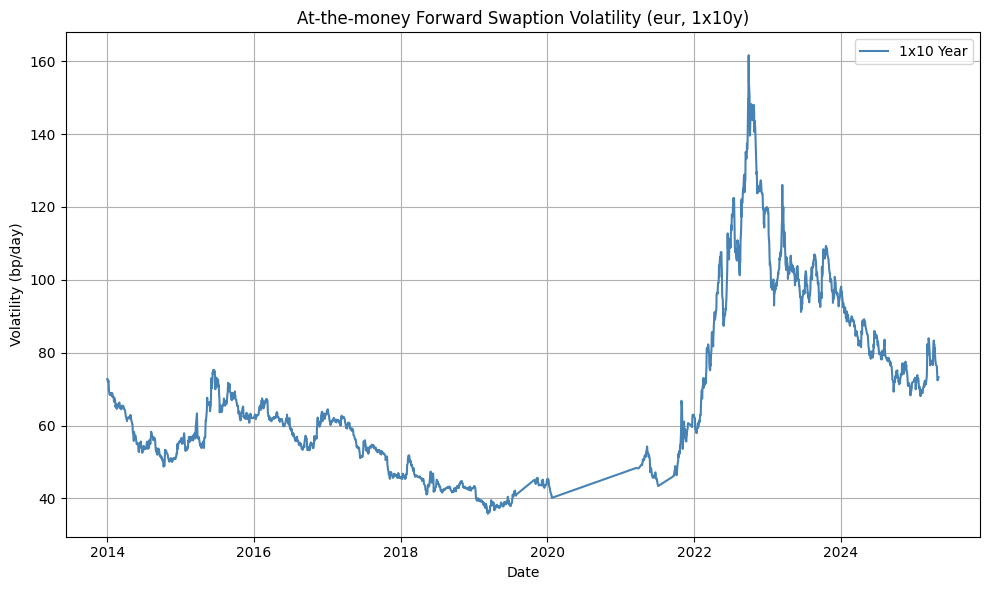

In [11]:
# Example: Plot 1x10y (start_months=12, tenor_months=120) swaption volatility over time
structure = (12, 120)
df_eur = eur_regression_df[(eur_regression_df['start_months'] == structure[0]) &(eur_regression_df['tenor_months'] == structure[1])].copy()
df_eur['date'] = pd.to_datetime(df_eur['date'])
df_eur = df_eur.sort_values('date')

plt.figure(figsize=(10, 6))
plt.plot(df_eur['date'], df_eur['value_bp_vol'], label='1x10 Year', color='steelblue')
plt.title('At-the-money Forward Swaption Volatility (eur, 1x10y)')
plt.xlabel('Date')
plt.ylabel('Volatility (bp/day)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

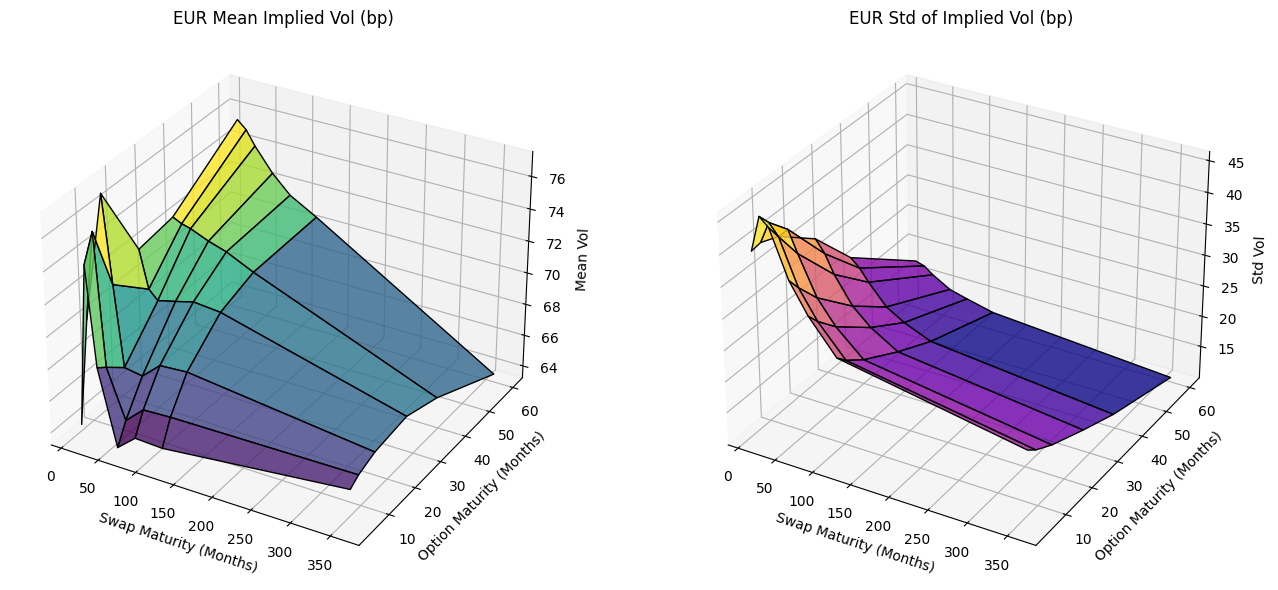

In [12]:
from mpl_toolkits.mplot3d import Axes3D

# Group by expiry (start_months) and tenor (tenor_months)
grouped = eur_regression_df.groupby(['start_months', 'tenor_months'])['value_bp_vol']
mean_vol = grouped.mean().unstack()
std_vol = grouped.std().unstack()
X, Y = np.meshgrid(mean_vol.columns, mean_vol.index)
fig = plt.figure(figsize=(14, 6))

# Mean surface
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(X, Y, mean_vol.values, cmap='viridis', edgecolor='k', alpha=0.8)
ax1.set_title('EUR Mean Implied Vol (bp)')
ax1.set_xlabel('Swap Maturity (Months)')
ax1.set_ylabel('Option Maturity (Months)')
ax1.set_zlabel('Mean Vol')

# Std surface
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(X, Y, std_vol.values, cmap='plasma', edgecolor='k', alpha=0.8)
ax2.set_title('EUR Std of Implied Vol (bp)')
ax2.set_xlabel('Swap Maturity (Months)')
ax2.set_ylabel('Option Maturity (Months)')
ax2.set_zlabel('Std Vol')

plt.tight_layout()
plt.show()

# Step 1: Functional form


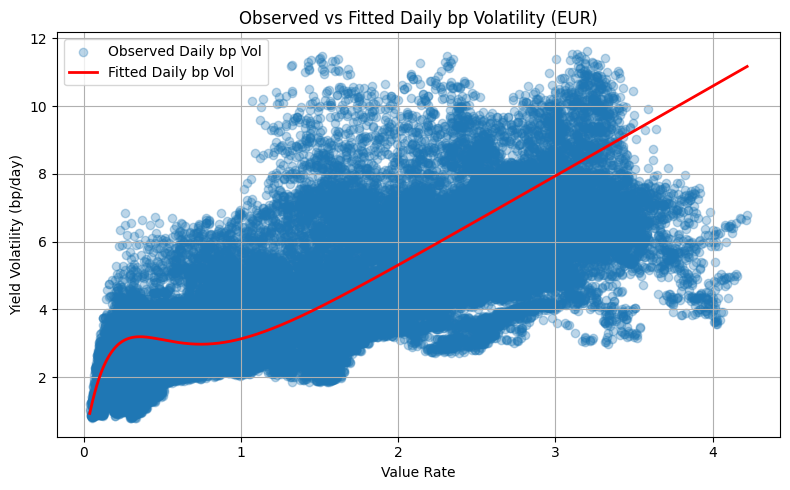

In [13]:
df_sorted = eur_regression_df.sort_values(by='value_rate')

plt.figure(figsize=(8,5))
plt.scatter(df_sorted['value_rate'], df_sorted['value_bp_vol_daily'],alpha=0.3, label='Observed Daily bp Vol')
plt.plot(df_sorted['value_rate'], df_sorted['fitted_yield_vol'], color='red', linewidth=2, label='Fitted Daily bp Vol')
plt.xlabel('Value Rate')
plt.ylabel('Yield Volatility (bp/day)')
plt.title('Observed vs Fitted Daily bp Volatility (EUR)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

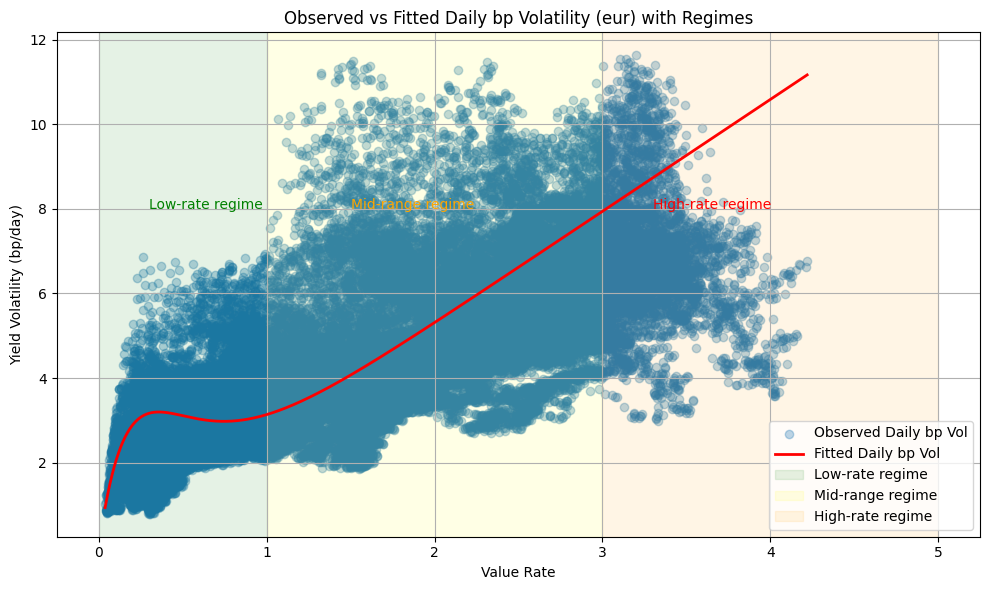

In [14]:
# Sort dataframe by value_rate
df_sorted = eur_regression_df.sort_values(by='value_rate')

plt.figure(figsize=(10,6))
plt.scatter(df_sorted['value_rate'], df_sorted['value_bp_vol_daily'], alpha=0.3, label='Observed Daily bp Vol')
plt.plot(df_sorted['value_rate'], df_sorted['fitted_yield_vol'], color='red', linewidth=2, label='Fitted Daily bp Vol')

# Add shaded regions for regimes
plt.axvspan(0, 1, color='green', alpha=0.1, label='Low-rate regime')
plt.axvspan(1, 3, color='yellow', alpha=0.1, label='Mid-range regime')
plt.axvspan(3, 5, color='orange', alpha=0.1, label='High-rate regime')

# Add text annotations
plt.text(0.3, 8, 'Low-rate regime', fontsize=10, color='green')
plt.text(1.5, 8, 'Mid-range regime', fontsize=10, color='orange')
plt.text(3.3, 8, 'High-rate regime', fontsize=10, color='red')

plt.xlabel('Value Rate')
plt.ylabel('Yield Volatility (bp/day)')
plt.title('Observed vs Fitted Daily bp Volatility (eur) with Regimes')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


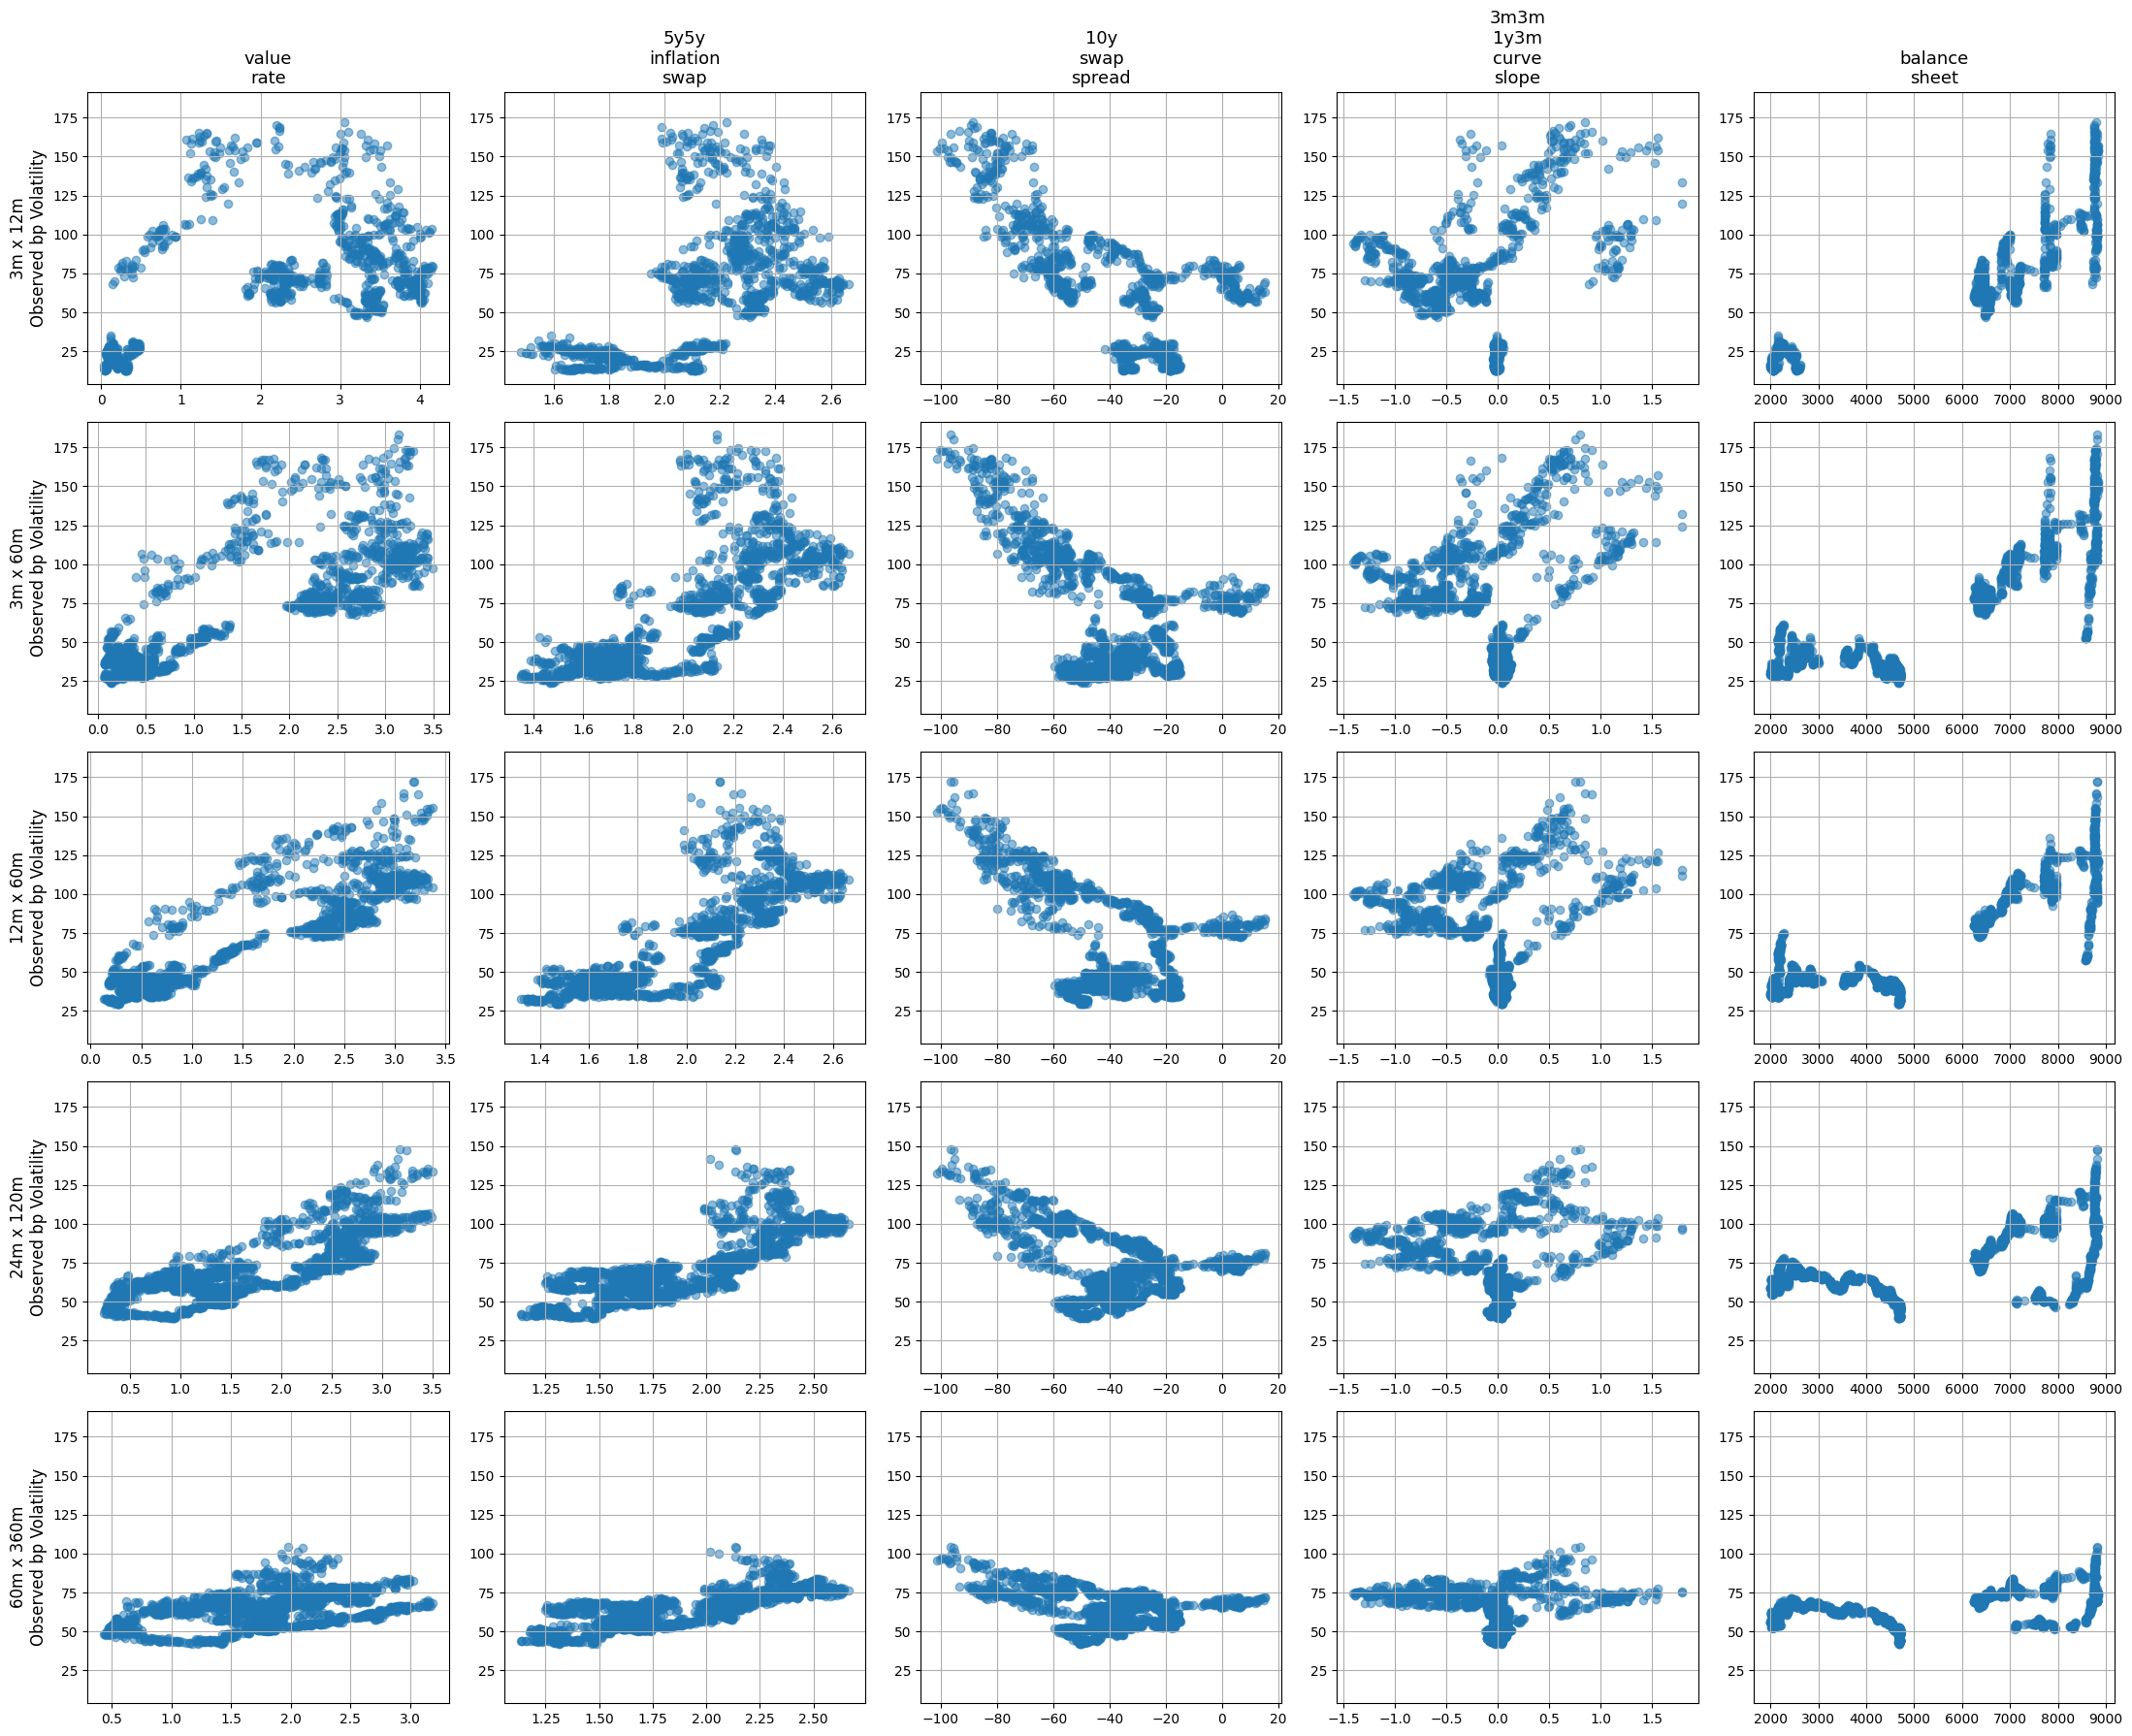

In [19]:
# Plot Volatility vs Each Macro Factor for 5 swaption structure combinations

combinations = [(3, 12), (3, 60), (12, 60), (24, 120), (60, 360)]
macro_factors = [
    'value_rate',
    '5y5y_inflation_swap',
    '10y_swap_spread',
    '3m3m_1y3m_curve_slope',
    'balance_sheet'
]

fig, axes = plt.subplots(len(combinations), len(macro_factors), figsize=(22, 18), sharey='col')
for row, (start, tenor) in enumerate(combinations):
    structure_df = eur_regression_df.query("start_months == @start and tenor_months == @tenor").dropna()
    for col, factor in enumerate(macro_factors):
        ax = axes[row, col]
        ax.scatter(structure_df[factor], structure_df['value_bp_vol'], alpha=0.5)
        if row == 0:
            ax.set_title(factor.replace('_', '\n'), fontsize=13)
        if col == 0:
            ax.set_ylabel(f'{start}m x {tenor}m\nObserved bp Volatility', fontsize=12)
        else:
            ax.set_ylabel('', fontsize=15)
        ax.set_xlabel('', fontsize=15)
        ax.grid(True)
plt.tight_layout()
plt.show()

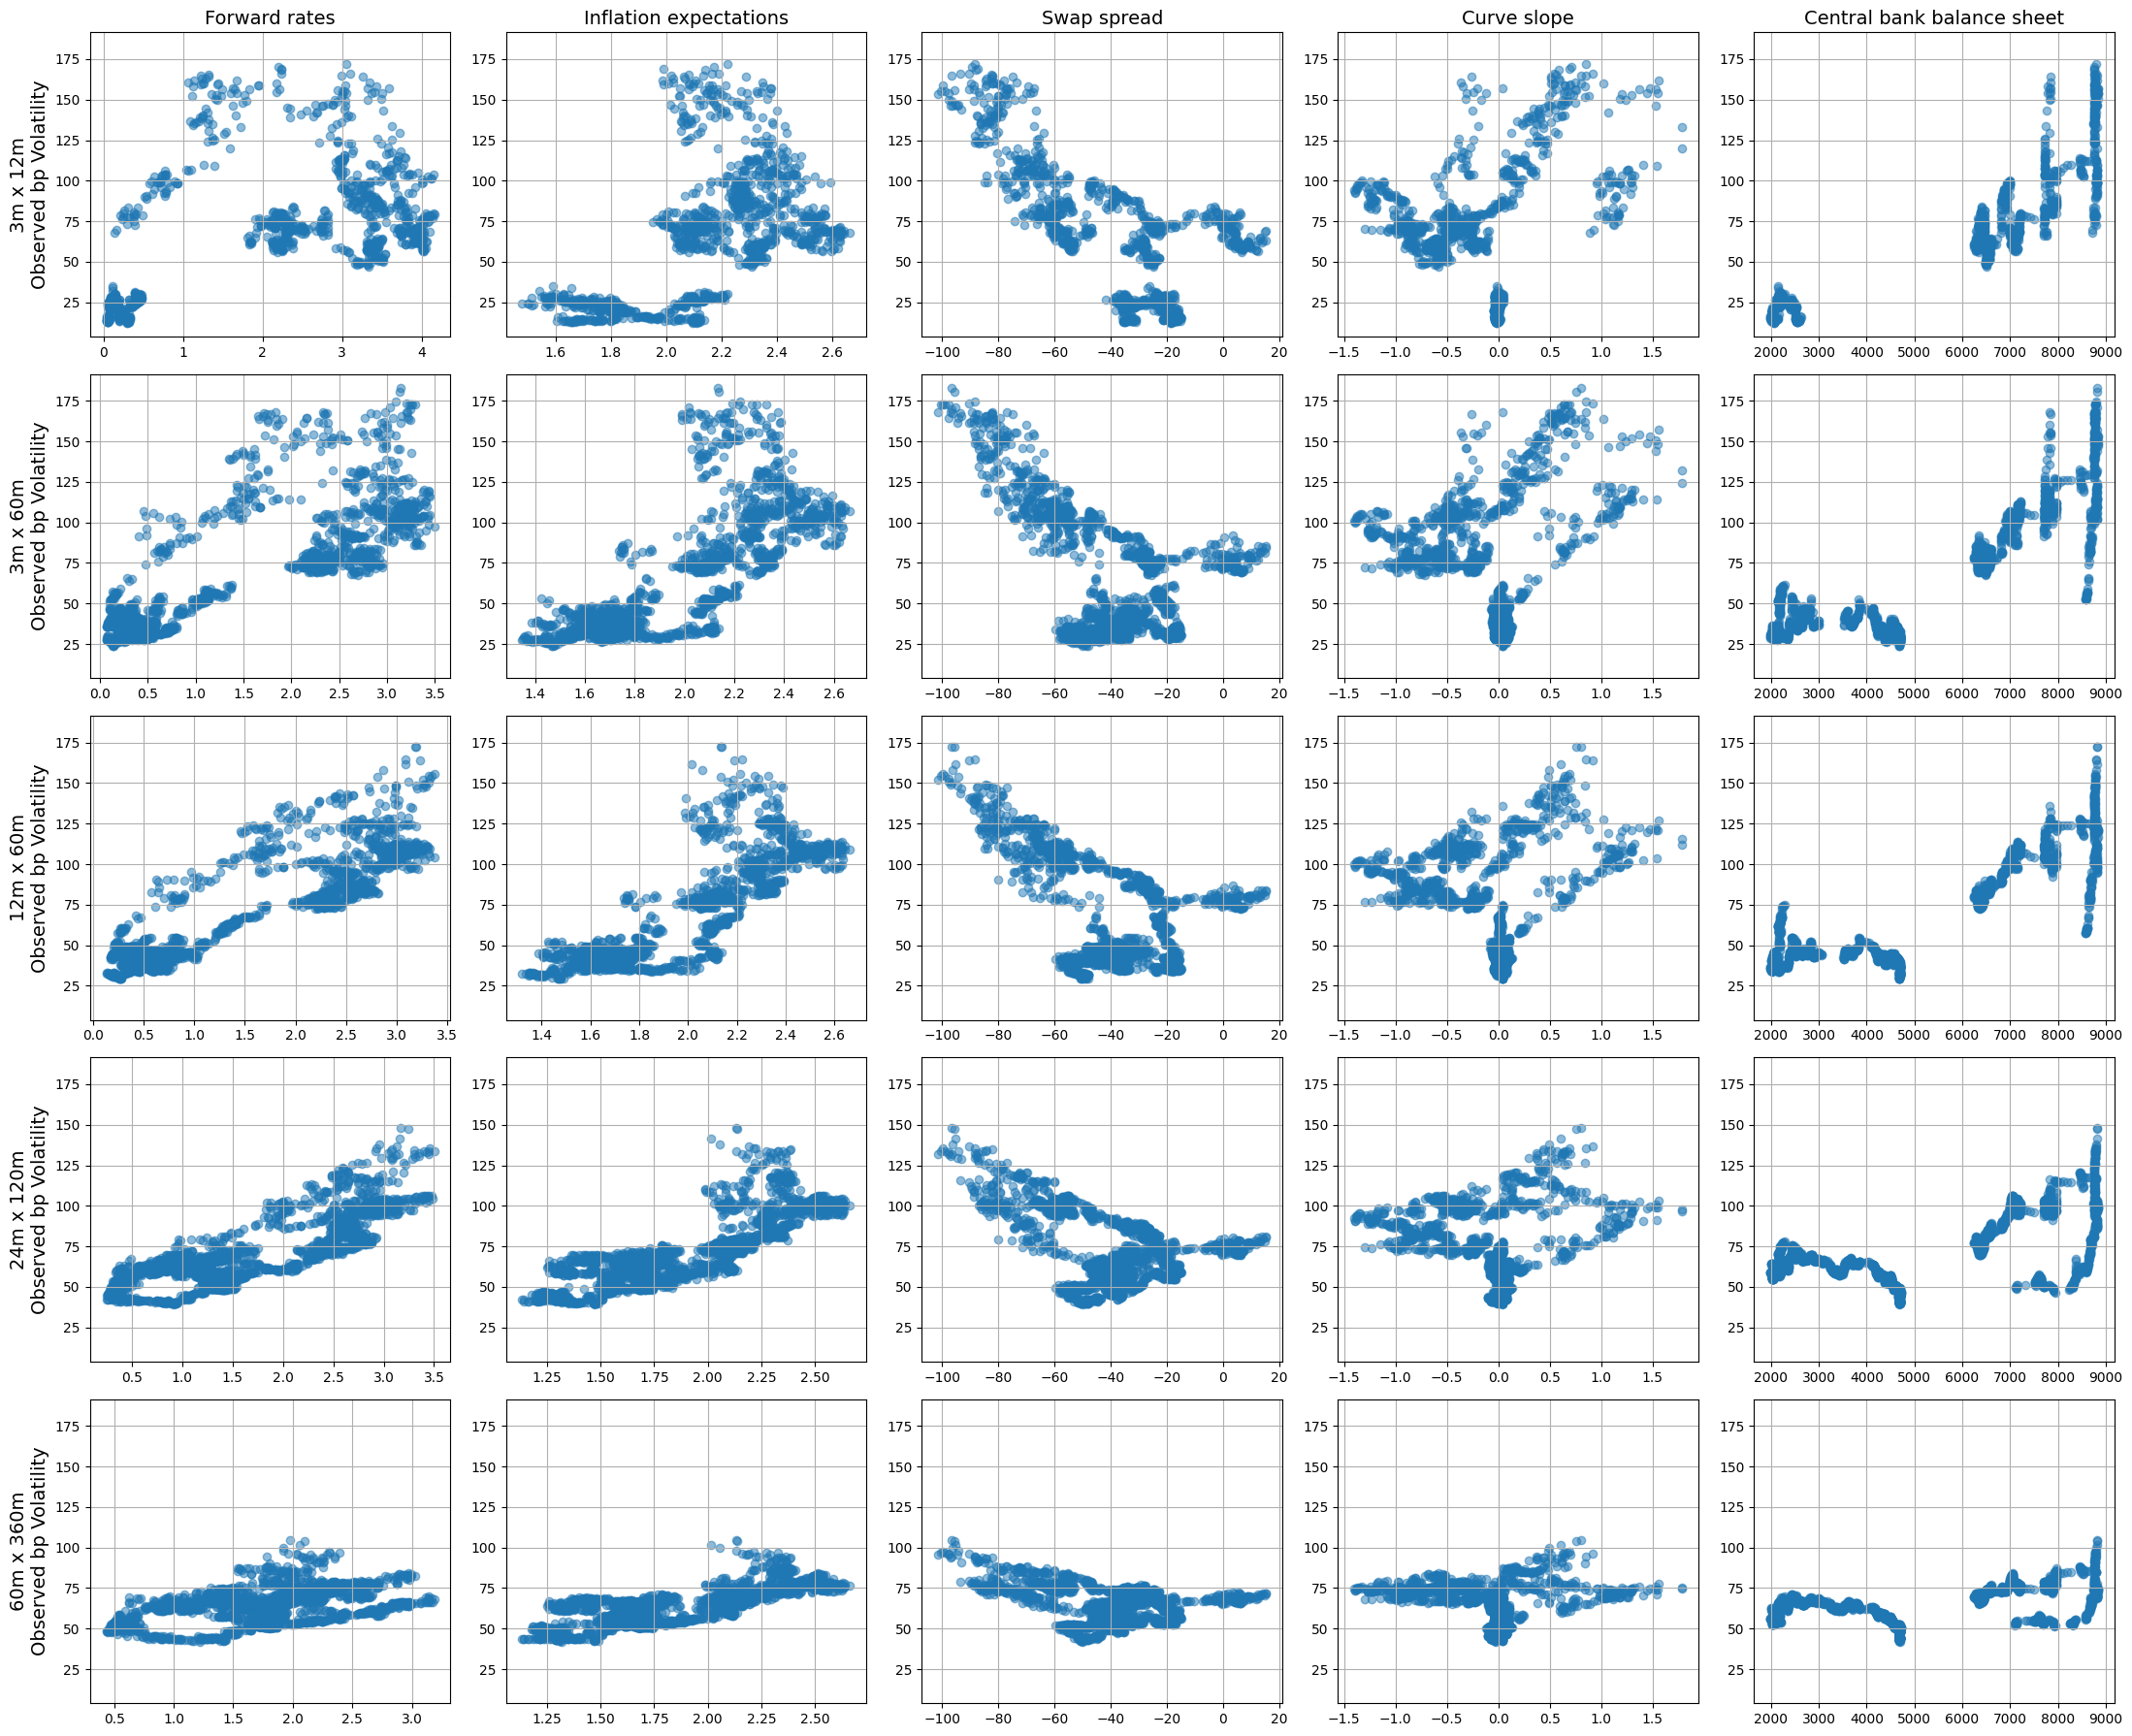

In [20]:
# Pretty labels for the x-axes
combinations = [(3, 12), (3, 60), (12, 60), (24, 120), (60, 360)]
label_map = {
    'value_rate': 'Forward rates',
    '5y5y_inflation_swap': 'Inflation expectations',
    'balance_sheet': 'Central bank balance sheet',
    '10y_swap_spread': 'Swap spread',
    '3m3m_1y3m_curve_slope': 'Curve slope',
}

fig, axes = plt.subplots(len(combinations), len(macro_factors),
                         figsize=(22, 18), sharey='col')

for row, (start, tenor) in enumerate(combinations):
    structure_df = eur_regression_df.query("start_months == @start and tenor_months == @tenor").dropna()
    for col, factor in enumerate(macro_factors):
        ax = axes[row, col]
        ax.scatter(structure_df[factor], structure_df['value_bp_vol'], alpha=0.5)

        # Column titles
        if row == 0:
            ax.set_title(label_map[factor], fontsize=14)

        # Row y-labels
        if col == 0:
            ax.set_ylabel(f'{start}m x {tenor}m\nObserved bp Volatility', fontsize=14)
        else:
            ax.set_ylabel('')

        ax.grid(True)

plt.tight_layout()
plt.show()
